##### Copyright 2019 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Guardar y cargar un modelo usando una estrategia de distribución

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/distribute/save_and_load"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/save_and_load.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/save_and_load.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/distribute/save_and_load.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar bloc de notas</a>
</td>
</table>

## Visión general

En este tutorial se muestra el modo de guardar y cargar modelos en formato SavedModel con `tf.distribute.Strategy` durante o después del entrenamiento. Hay dos tipos de API para guardar y cargar un modelo Keras: de alto nivel (`tf.keras.Model.save` y `tf.keras.models.load_model`) y de bajo nivel (`tf.saved_model.save` y `tf.saved_model.load`).

Para aprender sobre SavedModel y la serialización en general, lea la [guía de modelo guardado](../../guide/saved_model.ipynb), y la [guía de serialización de modelo Keras](https://www.tensorflow.org/guide/keras/save_and_serialize). Empecemos con un ejemplo simple.

Advertencia: Los modelos TensorFlow son código y debe tener cuidado con el código que no sea de confianza. Aprenda más en [Usar TensorFlow de forma segura](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md).


Importar dependencias:

In [ ]:
import tensorflow_datasets as tfds

import tensorflow as tf


Cargue y prepare los datos con conjuntos de datos TensorFlow y `tf.data`, y cree el modelo utilizando `tf.distribute.MirroredStrategy`:

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()

def get_data():
  datasets = tfds.load(name='mnist', as_supervised=True)
  mnist_train, mnist_test = datasets['train'], datasets['test']

  BUFFER_SIZE = 10000

  BATCH_SIZE_PER_REPLICA = 64
  BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255

    return image, label

  train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

  return train_dataset, eval_dataset

def get_model():
  with mirrored_strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.metrics.SparseCategoricalAccuracy()])
    return model

Entrene el modelo con `tf.keras.Model.fit`: 

In [ ]:
model = get_model()
train_dataset, eval_dataset = get_data()
model.fit(train_dataset, epochs=2)

## Guardar y cargar el modelo

Ahora que tiene un modelo sencillo con el que trabajar, exploremos las API de guardado/carga. Hay dos tipos de API disponibles:

- Alto nivel (Keras): `Model.save` y `tf.keras.models.load_model` (formato de archivo zip `.keras`)
- Bajo nivel: `tf.saved_model.save` y `tf.saved_model.load` (formato TF SavedModel)


### La API Keras

He aquí un ejemplo de cómo guardar y cargar un modelo con la API de Keras:

In [ ]:
keras_model_path = '/tmp/keras_save.keras'
model.save(keras_model_path)

Restaure el modelo sin `tf.distribute.Strategy`:

In [ ]:
restored_keras_model = tf.keras.models.load_model(keras_model_path)
restored_keras_model.fit(train_dataset, epochs=2)

Una vez restaurado el modelo, puede seguir entrenando sobre él, incluso sin necesidad de volver a llamar a `Model.compile`, puesto que ya estaba compilado antes de guardarlo. El modelo se guarda en formato de archivo zip de Keras, marcado con la extensión `.keras`. Para más información, consulte [la guía sobre guardado de Keras](https://www.tensorflow.org/guide/keras/save_and_serialize).

Ahora, restaure el modelo y entrénelo usando una `tf.distribute.Strategy`:

In [ ]:
another_strategy = tf.distribute.OneDeviceStrategy('/cpu:0')
with another_strategy.scope():
  restored_keras_model_ds = tf.keras.models.load_model(keras_model_path)
  restored_keras_model_ds.fit(train_dataset, epochs=2)

Como muestra la salida `Model.fit`, la carga funciona como se esperaba con `tf.distribute.Strategy`. La estrategia usada aquí no tiene por qué ser la misma usada antes de guardar. 

### La API `tf.saved_model`

Guardar el modelo con la API de nivel inferior es parecido a hacerlo con la API de Keras:

In [ ]:
model = get_model()  # get a fresh model
saved_model_path = '/tmp/tf_save'
tf.saved_model.save(model, saved_model_path)

Se puede cargar con `tf.saved_model.load`. Sin embargo, dado que se trata de una API de nivel más bajo (y, por tanto, tiene una gama más amplia de casos de uso), no devuelve un modelo Keras. En su lugar, devuelve un objeto que contiene funciones que pueden usarse para hacer inferencias. Por ejemplo:

In [ ]:
DEFAULT_FUNCTION_KEY = 'serving_default'
loaded = tf.saved_model.load(saved_model_path)
inference_func = loaded.signatures[DEFAULT_FUNCTION_KEY]

El objeto cargado puede contener varias funciones, cada una asociada a una clave. La clave `"serving_default"` es la clave predeterminada para la función de inferencia con un modelo Keras guardado. Para realizar la inferencia con esta función: 

In [ ]:
predict_dataset = eval_dataset.map(lambda image, label: image)
for batch in predict_dataset.take(1):
  print(inference_func(batch))

También puede cargar y realizar inferencias de forma distribuida:

In [ ]:
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  loaded = tf.saved_model.load(saved_model_path)
  inference_func = loaded.signatures[DEFAULT_FUNCTION_KEY]

  dist_predict_dataset = another_strategy.experimental_distribute_dataset(
      predict_dataset)

  # Calling the function in a distributed manner
  for batch in dist_predict_dataset:
    result = another_strategy.run(inference_func, args=(batch,))
    print(result)
    break

Llamar a la función restaurada es sólo un pase hacia adelante sobre el modelo guardado (`tf.keras.Model.predict`). ¿Y si desea seguir entrenando la función cargada? ¿O qué pasa si necesita incrustar la función cargada en un modelo más grande? Una práctica común es empaquetar este objeto cargado en una capa Keras para conseguirlo. Por suerte, [TF Hub](https://www.tensorflow.org/hub) dispone de [`hub.KerasLayer`](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/keras_layer.py) con este fin, como se muestra aquí:

In [ ]:
import tensorflow_hub as hub

def build_model(loaded):
  x = tf.keras.layers.Input(shape=(28, 28, 1), name='input_x')
  # Wrap what's loaded to a KerasLayer
  keras_layer = hub.KerasLayer(loaded, trainable=True)(x)
  model = tf.keras.Model(x, keras_layer)
  return model

another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  loaded = tf.saved_model.load(saved_model_path)
  model = build_model(loaded)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])
  model.fit(train_dataset, epochs=2)

En el ejemplo anterior, `hub.KerasLayer` de Tensorflow Hub envuelve el resultado cargado de nuevo desde `tf.saved_model.load` en una capa Keras que se usa para construir otro modelo. Esto es muy útil para el aprendizaje por transferencia. 

### ¿Qué API debiera usar?

Para guardar, si está trabajando con un modelo Keras, use el Keras `Model.save` a menos que necesite el control adicional que permite la API de bajo nivel. Si lo que está guardando no es un modelo Keras, entonces la API de bajo nivel, `tf.saved_model.save`, es su única opción.

Para cargar, su elección de API depende de lo que quiera recibir de la API de carga de modelos. Si no puede (o no quiere) recibir un modelo Keras, entonces use `tf.saved_model.load`. De lo contrario, use `tf.keras.models.load_model`. Tenga en cuenta que sólo puede recuperar un modelo Keras si ha guardado un modelo Keras.

Es posible combinar las API. Puede guardar un modelo Keras con `Model.save`, y cargar un modelo que no sea Keras con la API de bajo nivel, `tf.saved_model.load`. 

In [ ]:
model = get_model()

# Saving the model using Keras `Model.save`
model.save(saved_model_path)

another_strategy = tf.distribute.MirroredStrategy()
# Loading the model using the lower-level API
with another_strategy.scope():
  loaded = tf.saved_model.load(saved_model_path)

### Guardar/cargar desde un dispositivo local

Al guardar y cargar desde un dispositivo de E/S local mientras se entrena en dispositivos remotos (por ejemplo, al usar una TPU Cloud), debe usar la opción `experimental_io_device` en `tf.saved_model.SaveOptions` y `tf.saved_model.LoadOptions` para fijar el dispositivo de E/S en `localhost`. Por ejemplo:

In [ ]:
model = get_model()

# Saving the model to a path on localhost.
saved_model_path = '/tmp/tf_save'
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save(saved_model_path, options=save_options)

# Loading the model from a path on localhost.
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
  loaded = tf.keras.models.load_model(saved_model_path, options=load_options)

### Precauciones

Un caso especial es cuando se crean modelos Keras de determinadas formas y luego se guardan antes de entrenar. Por ejemplo:

In [ ]:
class SubclassedModel(tf.keras.Model):
  """Example model defined by subclassing `tf.keras.Model`."""

  output_name = 'output_layer'

  def __init__(self):
    super(SubclassedModel, self).__init__()
    self._dense_layer = tf.keras.layers.Dense(
        5, dtype=tf.dtypes.float32, name=self.output_name)

  def call(self, inputs):
    return self._dense_layer(inputs)

my_model = SubclassedModel()
try:
  my_model.save(saved_model_path)
except ValueError as e:
  print(f'{type(e).__name__}: ', *e.args)

Un SavedModel guarda los objetos `tf.types.experimental.ConcreteFunction` generados al rastrear una `tf.function` (consulte *¿Cuándo se rastrea una Función?* en la guía [Introducción a los grafos y tf.function](../../guide/intro_to_graphs.ipynb) para obtener más información). Si obtiene un `ValueError` como este, es porque `Model.save` no fue capaz de encontrar o crear una `ConcreteFunction` rastreada.

**Precaución:** No debería guardar un modelo sin al menos una `ConcreteFunction`, ya que, de lo contrario, la API de bajo nivel generará un SavedModel sin firmas `ConcreteFunction` ([aprenda más](../../guide/saved_model.ipynb) sobre el formato SavedModel). Por ejemplo:

In [ ]:
tf.saved_model.save(my_model, saved_model_path)
x = tf.saved_model.load(saved_model_path)
x.signatures

Normalmente, la pasada hacia delante del modelo (el método `call`) se rastrea automáticamente cuando se llama al modelo por primera vez, a menudo a través del método `Model.fit` de Keras. Una `ConcreteFunction` también puede ser generada por las API [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) y [Functional](https://www.tensorflow.org/guide/keras/functional) de Keras, si se configura la forma de entrada, por ejemplo, haciendo la primer capa ya sea un `tf.keras.layers.InputLayer` u otro tipo de capa, y pasándole el argumento de palabra clave `input_shape`.

Para verificar si su modelo tiene alguna `ConcreteFunction` rastreada, compruebe si `Model.save_spec` es `None`:

In [ ]:
print(my_model.save_spec() is None)

Usemos `tf.keras.Model.fit` para entrenar el modelo, y notemos que el `save_spec` queda definido y el guardado del modelo funcionará:

In [ ]:
BATCH_SIZE_PER_REPLICA = 4
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

dataset_size = 100
dataset = tf.data.Dataset.from_tensors(
    (tf.range(5, dtype=tf.float32), tf.range(5, dtype=tf.float32))
    ).repeat(dataset_size).batch(BATCH_SIZE)

my_model.compile(optimizer='adam', loss='mean_squared_error')
my_model.fit(dataset, epochs=2)

print(my_model.save_spec() is None)
my_model.save(saved_model_path)

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Entrenamiento personalizado con tf.distribute.Strategy

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/distribute/custom_training"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/custom_training.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/custom_training.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/distribute/custom_training.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a>
</td>
</table>

Este tutorial muestra cómo usar `tf.distribute.Strategy`, una API de TensorFlow que da una abstracción para [distribuir su entrenamiento](../../guide/distributed_training.ipynb) entre múltiples unidades de procesamiento (GPUs, múltiples máquinas o TPUs), con bucles de entrenamiento personalizados. Aquí entrenarás una red neuronal convolucional sencilla en el conjunto de datos [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), que contiene 70,000 imágenes de tamaño 28 x 28.

Los [bucles de entrenamiento personalizados](../customization/custom_training_walkthrough.ipynb) dan flexibilidad y un mayor control sobre el entrenamiento. También facilitan depurar el modelo y el bucle de entrenamiento.

In [ ]:
# Import TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import os

print(tf.__version__)

## Descargar el conjunto de datos Fashion MNIST

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Add a dimension to the array -> new shape == (28, 28, 1)
# This is done because the first layer in our model is a convolutional
# layer and it requires a 4D input (batch_size, height, width, channels).
# batch_size dimension will be added later on.
train_images = train_images[..., None]
test_images = test_images[..., None]

# Scale the images to the [0, 1] range.
train_images = train_images / np.float32(255)
test_images = test_images / np.float32(255)

## Cree una estrategia para distribuir las variables y el grafo

¿Cómo funciona la estrategia `tf.distribute.MirroredStrategy`?

- Todas las variables y el grafo del modelo se reproducen en las réplicas.
- Las entradas se distribuyen uniformemente entre las réplicas.
- Cada réplica calcula la pérdida y los gradientes de la entrada que ha recibido.
- Se **suman** los gradientes de todas las réplicas para sincronizarlos.
- Tras la sincronización, se realiza la misma actualización en las copias de las variables de cada réplica.

Nota: Puedes poner todo el código siguiente dentro de un único ámbito. Este ejemplo lo divide en varias celdas de código para ilustrarlo.


In [ ]:
# If the list of devices is not specified in
# `tf.distribute.MirroredStrategy` constructor, they will be auto-detected.
strategy = tf.distribute.MirroredStrategy()

In [ ]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

## Configurar la canalización de entrada

In [ ]:
BUFFER_SIZE = len(train_images)

BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCHS = 10

Crea los conjuntos de datos y distribúyelos:

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(GLOBAL_BATCH_SIZE)

train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

## Crear el modelo

Crea un modelo usando `tf.keras.Sequential`. También puedes usar la [API de subclase de modelos](https://www.tensorflow.org/guide/keras/custom_layers_and_models) o la [API funcional](https://www.tensorflow.org/guide/keras/functional) para hacerlo.

In [ ]:
def create_model():
  regularizer = tf.keras.regularizers.L2(1e-5)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3,
                             activation='relu',
                             kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3,
                             activation='relu',
                             kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64,
                            activation='relu',
                            kernel_regularizer=regularizer),
      tf.keras.layers.Dense(10, kernel_regularizer=regularizer)
    ])

  return model

In [ ]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

## Definir la función de pérdida

Recordemos que la función de pérdida consta de una o dos partes:

- La **pérdida por predicción** mide lo alejadas que están las predicciones del modelo de las etiquetas de entrenamiento para un lote de ejemplos de entrenamiento. Se calcula para cada ejemplo etiquetado y luego se reduce para todo el lote calculando el valor promedio.
- Opcionalmente, se pueden añadir términos de **pérdida por regularización** a la pérdida por predicción, para evitar que el modelo se ajuste en exceso a los datos del entrenamiento. Una elección común es la regularización L2, que añade un pequeño múltiplo fijo de la suma de cuadrados de todas las ponderaciones del modelo, independientemente del número de ejemplos. El modelo anterior usa la regularización L2 para demostrar su manejo en el bucle de entrenamiento a continuación.

Para el entrenamiento en una sola máquina con una sola GPU/CPU, esto funciona de la siguiente manera:

- La pérdida por predicción se calcula para cada ejemplo del lote, se suma para todo el lote y luego se divide por el tamaño del lote.
- La pérdida por regularización se añade a la pérdida por predicción.
- El gradiente de la pérdida total se calcula respecto a cada ponderación del modelo, y el optimizador actualiza cada ponderación del modelo a partir del gradiente correspondiente.

Con `tf.distribute.Strategy`, el lote de entrada se divide entre las réplicas. Por ejemplo, supongamos que tiene 4 GPUs, cada una con una réplica del modelo. Un lote de 256 ejemplos de entrada se distribuye uniformemente entre las 4 réplicas, por lo que cada réplica recibe un lote de tamaño 64: Tenemos `256 = 4*64`, o en general `GLOBAL_BATCH_SIZE = num_replicas_in_sync * BATCH_SIZE_PER_REPLICA`.

Cada réplica calcula la pérdida a partir de los ejemplos de entrenamiento que obtiene y calcula los gradientes de la pérdida respecto a cada ponderación del modelo. El optimizador se encarga de que estos **gradientes se sumen en todas las réplicas** antes de usarlos para actualizar las copias de las ponderaciones del modelo en cada réplica.

*Entonces, ¿cómo se debe calcular la pérdida cuando se usa una `tf.distribute.Strategy`?*

- Cada réplica calcula la pérdida por predicción de todos los ejemplos que se le han distribuido, suma los resultados y los divide entre `num_replicas_in_sync * BATCH_SIZE_PER_REPLICA`, o lo que es lo mismo, `GLOBAL_BATCH_SIZE`.
- Cada réplica computa la(s) pérdida(s) por regularización y las divide entre `num_replicas_in_sync`.

En comparación con el entrenamiento no distribuido, todos los términos de pérdida por cada réplica se reducen en un factor de `1/num_replicas_in_sync`. Por otra parte, todos los términos de pérdida (o mejor dicho, sus gradientes) se suman a lo largo de ese número de réplicas antes de que el optimizador los aplique. En efecto, el optimizador en cada réplica usa los mismos gradientes que si se hubiera producido un cálculo no distribuido con `GLOBAL_BATCH_SIZE`. Esto es consistente con el comportamiento distribuido y no distribuido de `Model.fit` de Keras. Véase el tutorial [Entrenamiento distribuido con Keras](./keras.ipynb) sobre cómo un mayor tamaño de lote global permite escalar la tasa de aprendizaje.

*¿Cómo hacerlo en TensorFlow?*

- La reducción de pérdidas y el escalado se realizan automáticamente en `Model.compile` y `Model.fit` de Keras

- Si está escribiendo un bucle de entrenamiento personalizado, como en este tutorial, debe sumar las pérdidas por cada ejemplo y dividir la suma entre el tamaño global del lote utilizando `tf.nn.compute_average_loss`, que toma las pérdidas por cada ejemplo y las ponderaciones opcionales de las muestras como argumentos y devuelve la pérdida escalada.

- Si se usan las clases `tf.keras.losses` (como en el ejemplo siguiente), es necesario especificar explícitamente que la reducción de pérdidas sea una de las siguientes `NONE` o `SUM`. Los valores predeterminados `AUTO` y `SUM_OVER_BATCH_SIZE` no están permitidos fuera de `Model.fit`.

    - `AUTO` no está permitido porque el usuario debe pensar explícitamente qué reducción desea para asegurarse de que es correcta en el caso distribuido.
    - `SUM_OVER_BATCH_SIZE` no está permitido porque actualmente sólo dividiría entre el tamaño del lote por réplica, y dejaría la división entre el número de réplicas al usuario, lo que podría ser fácil de pasar por alto. Así que, en su lugar, tiene que hacer la reducción usted mismo de forma explícita.

- Si está escribiendo un bucle de entrenamiento personalizado para un modelo con una lista no vacía de `Model.losses` (por ejemplo, regularizadores de ponderación), debe sumarlos y dividir la suma entre el número de réplicas. Puede hacerlo usando la función `tf.nn.scale_regularization_loss`. El propio código del modelo permanece ajeno al número de réplicas.

Sin embargo, los modelos pueden definir pérdidas de regularización dependientes de la entrada con API de Keras como `Layer.add_loss(...)` y `Layer(activity_regularizer=...)`. Para `Layer.add_loss(...)`, corresponde al código de modelado realizar la división de los términos sumados por cada ejemplo entre el tamaño del lote por cada réplica(!), por ejemplo, usando `tf.math.reduce_mean()`.

In [ ]:
with strategy.scope():
  # Set reduction to `NONE` so you can do the reduction yourself.
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE)
  def compute_loss(labels, predictions, model_losses):
    per_example_loss = loss_object(labels, predictions)
    loss = tf.nn.compute_average_loss(per_example_loss)
    if model_losses:
      loss += tf.nn.scale_regularization_loss(tf.add_n(model_losses))
    return loss

### Casos especiales

Los usuarios avanzados también deben tener en cuenta los siguientes casos especiales.

- Los lotes de entrada más cortos que `GLOBAL_BATCH_SIZE` crean casos límite desagradables en varios lugares. En la práctica, suele funcionar mejor evitarlos permitiendo que los lotes abarquen los límites de las épocas usando `Dataset.repeat().batch()` y definiendo las épocas aproximadas por conteos de pasos, no por los extremos de los conjuntos de datos. Alternativamente, `Dataset.batch(drop_remainder=True)` mantiene la noción de época pero elimina algunos de los últimos ejemplos.

Como ilustración, este ejemplo va por el camino más difícil y permite lotes cortos, de modo que cada época de entrenamiento contenga cada ejemplo entrenado exactamente una vez.

¿Qué denominador debe usar `tf.nn.compute_average_loss()`?

```
* By default, in the example code above and equivalently in `Keras.fit()`, the sum of prediction losses is divided by `num_replicas_in_sync` times the actual batch size seen on the replica (with empty batches silently ignored). This preserves the balance between the prediction loss on the one hand and the regularization losses on the other hand. It is particularly appropriate for models that use input-dependent regularization losses. Plain L2 regularization just superimposes weight decay onto the gradients of the prediction loss and is less in need of such a balance.
* In practice, many custom training loops pass as a constant Python value into `tf.nn.compute_average_loss(..., global_batch_size=GLOBAL_BATCH_SIZE)` to use it as the denominator. This preserves the relative weighting of training examples between batches. Without it, the smaller denominator in short batches effectively upweights the examples in those. (Before TensorFlow 2.13, this was also needed to avoid NaNs in case some replica received an actual batch size of zero.)
```

Ambas opciones son equivalentes si se evitan los lotes cortos, como se ha sugerido anteriormente.

- Las `labels` multidimensionales requieren que se promedie la `per_example_loss` entre el número de predicciones en cada ejemplo. Considere una tarea de clasificación para todos los pixeles de una imagen de entrada, con `predictions` de forma `(batch_size, H, W, n_classes)` y `labels` de forma `(batch_size, H, W)`. Tendrá que actualizar `per_example_loss` como: `per_example_loss /= tf.cast(tf.reduce_prod(tf.shape(labels)[1:]), tf.float32)`

Precaución: **Verifique la forma de su pérdida**. Las funciones de pérdida en `tf.losses`/`tf.keras.losses` suelen devolver el promedio sobre la última dimensión de la entrada. Las clases de pérdida envuelven estas funciones. Pasar `reduction=Reduction.NONE` al crear una instancia de una clase de pérdida significa "ninguna reducción **adicional**". Para las pérdidas categóricas con una forma de entrada de ejemplo de `[batch, W, H, n_clases]` se reduce la dimensión `n_clases`. Para las pérdidas puntuales como `losses.mean_squared_error` o `losses.binary_crossentropy` incluye un eje ficticio de modo que `[batch, W, H, 1]` se reduzca a `[batch, W, H]`. Sin el eje ficticio, `[batch, W, H]` se reducirá incorrectamente a `[batch, W]`.

## Definir las métricas para controlar las pérdidas y la precisión

Estas métricas realizan un seguimiento de la pérdida por prueba y de la precisión del entrenamiento y de la prueba. Puedes usar `.result()` para obtener las estadísticas acumuladas en cualquier momento.

In [ ]:
with strategy.scope():
  test_loss = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')

## Bucle de entrenamiento

In [ ]:
# A model, an optimizer, and a checkpoint must be created under `strategy.scope`.
with strategy.scope():
  model = create_model()

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [ ]:
def train_step(inputs):
  images, labels = inputs

  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = compute_loss(labels, predictions, model.losses)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_accuracy.update_state(labels, predictions)
  return loss

def test_step(inputs):
  images, labels = inputs

  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss.update_state(t_loss)
  test_accuracy.update_state(labels, predictions)

In [ ]:
# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)

@tf.function
def distributed_test_step(dataset_inputs):
  return strategy.run(test_step, args=(dataset_inputs,))

for epoch in range(EPOCHS):
  # TRAIN LOOP
  total_loss = 0.0
  num_batches = 0
  for x in train_dist_dataset:
    total_loss += distributed_train_step(x)
    num_batches += 1
  train_loss = total_loss / num_batches

  # TEST LOOP
  for x in test_dist_dataset:
    distributed_test_step(x)

  if epoch % 2 == 0:
    checkpoint.save(checkpoint_prefix)

  template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, "
              "Test Accuracy: {}")
  print(template.format(epoch + 1, train_loss,
                         train_accuracy.result() * 100, test_loss.result(),
                         test_accuracy.result() * 100))

  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

### Cosas a notar en el ejemplo anterior:

- Iterar sobre el conjunto de datos `train_dist_dataset` y `test_dist_dataset` usando una construcción `for x in ...`.
- La pérdida escalada es el valor de retorno del `distributed_train_step`. Este valor se agrega entre réplicas usando la llamada `tf.distribute.Strategy.reduce` y luego entre lotes sumando el valor de retorno de las llamadas `tf.distribute.Strategy.reduce`.
- `tf.keras.Metrics` debe actualizarse dentro de `train_step` y `test_step` que es ejecutado por `tf.distribute.Strategy.run`.
- `tf.distribute.Strategy.run` devuelve resultados de cada réplica local de la estrategia, y hay varias formas de consumir este resultado. Puedes hacer `tf.distribute.Strategy.reduce` para obtener un valor agregado. También puedes hacer `tf.distribute.Strategy.experimental_local_results` para obtener la lista de valores contenidos en el resultado, uno por réplica local.


## Restaurar el último punto de verificación y probar

Un modelo verificado con un `tf.distribute.Strategy` puede restaurarse con o sin estrategia.

In [ ]:
eval_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='eval_accuracy')

new_model = create_model()
new_optimizer = tf.keras.optimizers.Adam()

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(GLOBAL_BATCH_SIZE)

In [ ]:
@tf.function
def eval_step(images, labels):
  predictions = new_model(images, training=False)
  eval_accuracy(labels, predictions)

In [ ]:
checkpoint = tf.train.Checkpoint(optimizer=new_optimizer, model=new_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for images, labels in test_dataset:
  eval_step(images, labels)

print('Accuracy after restoring the saved model without strategy: {}'.format(
    eval_accuracy.result() * 100))

## Formas alternativas de iterar sobre un conjunto de datos

### Usando iteradores

Si quieres iterar sobre un número determinado de pasos y no sobre todo el conjunto de datos, puedes crear un iterador utilizando la llamada `iter` y llamar explícitamente a `next` en el iterador. Puedes elegir iterar sobre el conjunto de datos tanto dentro como fuera de la `tf.function`. Aquí puedes ver un pequeño fragmento que demuestra la iteración sobre el conjunto de datos fuera de la `tf.function` usando un iterador.


In [ ]:
for _ in range(EPOCHS):
  total_loss = 0.0
  num_batches = 0
  train_iter = iter(train_dist_dataset)

  for _ in range(10):
    total_loss += distributed_train_step(next(train_iter))
    num_batches += 1
  average_train_loss = total_loss / num_batches

  template = ("Epoch {}, Loss: {}, Accuracy: {}")
  print(template.format(epoch + 1, average_train_loss, train_accuracy.result() * 100))
  train_accuracy.reset_states()

### Iterar dentro de una `tf.function`

También puedes iterar sobre toda la entrada `train_dist_dataset` dentro de una `tf.function` usando la construcción `for x in ...` o creando iteradores igual que hiciste antes. El siguiente ejemplo muestra cómo envolver una época de entrenamiento con un decorador `@tf.function` e iterar sobre `train_dist_dataset` dentro de la función.

In [ ]:
@tf.function
def distributed_train_epoch(dataset):
  total_loss = 0.0
  num_batches = 0
  for x in dataset:
    per_replica_losses = strategy.run(train_step, args=(x,))
    total_loss += strategy.reduce(
      tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    num_batches += 1
  return total_loss / tf.cast(num_batches, dtype=tf.float32)

for epoch in range(EPOCHS):
  train_loss = distributed_train_epoch(train_dist_dataset)

  template = ("Epoch {}, Loss: {}, Accuracy: {}")
  print(template.format(epoch + 1, train_loss, train_accuracy.result() * 100))

  train_accuracy.reset_states()

### Seguimiento de la pérdida por entrenamiento en las réplicas

Nota: Como regla general, debes usar `tf.keras.Metrics` para hacer un seguimiento de los valores por muestra y evitar los valores que se hayan agregado dentro de una réplica.

Puesto que se lleva a cabo un cálculo de escalado de pérdidas, no se recomienda usar `tf.keras.metrics.Mean` para hacer un seguimiento de la pérdida por entrenamiento en distintas réplicas.

Por ejemplo, si ejecutas un trabajo de entrenamiento con las siguientes características:

- Dos réplicas
- Se procesan dos muestreos en cada réplica
- Valores de pérdida resultantes: [2, 3] y [4, 5] en cada réplica
- Tamaño global del lote = 4

Con el escalado de pérdidas, calculas el valor de pérdida por muestra en cada réplica sumando los valores de pérdida y dividiéndolos por el tamaño global del lote. En este caso `(2 + 3) / 4 = 1,25` y `(4 + 5) / 4 = 2,25`.

Si usas `tf.keras.metrics.Mean` para hacer un seguimiento de la pérdida en las dos réplicas, el resultado es distinto. En este ejemplo, al final tienes un `total` de 3.50 y un `count` de 2, lo que da como resultado `total`/`count` = 1.75 cuando se llama a `result()` en la métrica. La pérdida calculada con `tf.keras.Metrics` se escala con un factor adicional que es igual al número de réplicas sincronizadas.

### Guía y ejemplos

Estos son algunos ejemplos de cómo usar la estrategia de distribución con bucles de entrenamiento personalizados:

1. [Guía de entrenamiento distribuido](../../guide/distributed_training)
2. Ejemplo de [DenseNet](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/densenet/distributed_train.py) usando `MirroredStrategy`.
3. Ejemplo de [BERT](https://github.com/tensorflow/models/blob/master/official/legacy/bert/run_classifier.py) entrenado usando `MirroredStrategy` y `TPUStrategy`. Este ejemplo es especialmente útil para entender cómo cargar desde un punto de verificación y generar puntos de verificación periódicos durante el entrenamiento distribuido, etc.
4. Ejemplo de [NCF](https://github.com/tensorflow/models/blob/master/official/recommendation/ncf_keras_main.py) entrenado usando `MirroredStrategy` que puede ser habilitado usando la bandera `keras_use_ctl`.
5. Ejemplo de [NMT](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/nmt_with_attention/distributed_train.py) entrenado usando `MirroredStrategy`.

Puedes encontrar más ejemplos en *Ejemplos y tutoriales* la [Guía de estrategias de distribución](../../guide/distributed_training.ipynb).

## Siguientes pasos

- Prueba la nueva API `tf.distribute.Strategy` en tus modelos.
- Visita las guías [Mejor rendimiento con `tf.function`](../../guide/function.ipynb) y [Perfilador TensorFlow](../../guide/profiler.md) para saber más sobre herramientas para optimizar el rendimiento de tus modelos TensorFlow.
- Consulta la guía [Entrenamiento distribuido en TensorFlow](../../guide/distributed_training.ipynb), que da una visión general de las estrategias de distribución disponibles.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Image Classification with Convolutional Neural Networks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [ ]:
import tensorflow as tf

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

Let's plot an image to see what it looks like.

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

> Note: Using `softmax` activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras` model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [ ]:
predictions.shape


Here, the model has predicted the probability of each label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

So the model is usually most confident that this image is a Shirt, or `class_names[6]`. Let's check the label:

In [ ]:
test_labels[0]

We can graph this to look at the full set of 10 class predictions

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

Now predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

And, as before, the model predicts a label of 6 (shirt).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Dogs vs Cats Image Classification Without Image Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`.

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — How can we efficiently work with data on disk to interface with our model?
* _Overfitting_ - what is it, how to identify it?

<hr>


**Before you begin**

Before running the code in this notebook, reset the runtime by going to **Runtime -> Reset all runtimes** in the menu above. If you have been working through several notebooks, this will help you avoid reaching Colab's memory limits.


# Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In previous Colabs, we've used <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a>, which is a very easy and convenient way to use datasets. In this Colab however, we will make use of the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to the Colab filesystem.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [ ]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

We'll now assign variables with the proper file path for the training and validation sets.

In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

Let's look at how many cats and dogs images we have in our training and validation directory

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

# Setting Model Parameters

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [ ]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [ ]:
sample_training_images, _ = next(train_data_gen) 

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [ ]:
model.summary()

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [ ]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

### Visualizing results of the training

We'll now visualize the results we get after training our network.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

print(tf.__version__)

# Download Fashion MNIST Dataset


In [ ]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [ ]:
# Write a function to normalize and resize the images

def format_example(image, label):
  # Cast image to float32
  image = # YOUR CODE HERE
  # Resize the image if necessary
  image = # YOUR CODE HERE
  # Normalize the image in the range [0, 1]
  image = # YOUR CODE HERE
  return image, label

In [ ]:
# Set the batch size to 32

BATCH_SIZE = 32

## Create a Dataset from images and labels

In [ ]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = # YOUR CODE HERE

validation_batches = # YOUR CODE HERE
test_batches = # YOUR CODE HERE

# Building the model

In [ ]:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
"""

In [ ]:
# Build the model shown in the previous cell


model = tf.keras.Sequential([
  # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,  
  tf.keras.layers.Conv2D(# YOUR CODE HERE),    
  tf.keras.layers.MaxPooling2D(),
  # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
  tf.keras.layers.Conv2D(# YOUR CODE HERE),
  # Flatten the output layer to 1 dimension
  tf.keras.layers.Flatten(),
  # Add a fully connected layer with 64 hidden units and ReLU activation
  tf.keras.layers.Dense(# YOUR CODE HERE),
  # Attach a final softmax classification head
  tf.keras.layers.Dense(# YOUR CODE HERE)])

# Set the loss and accuracy metrics
model.compile(
    optimizer='adam', 
    loss=# YOUR CODE HERE, 
    metrics=# YOUR CODE HERE)
      

## Train

In [ ]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

# Exporting to TFLite

In [ ]:
export_dir = 'saved_model/1'

# Use the tf.saved_model API to export the SavedModel

# Your Code Here

In [ ]:
optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = # YOUR CODE HERE

# Set the optimzations
converter.optimizations = # YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = # YOUR CODE HERE

In [ ]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test if your model is working

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 49 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [ ]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

# Deploying TFLite model

Now once you've the trained TFLite model downloaded, you can ahead and deploy this on an Android/iOS application by placing the model assets in the appropriate location.

# Prepare the test images for download (Optional)

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq fmnist_test_images.zip -r test_images/

In [ ]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass

# Convolutional Neural Network Example

Build a convolutional neural network with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building convolutional neural networks and the training process.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## CNN Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32 and normalized to [0, 1].

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [6]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [7]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 1.877234, accuracy: 0.789062
step: 20, loss: 1.609390, accuracy: 0.898438
step: 30, loss: 1.555458, accuracy: 0.960938
step: 40, loss: 1.588296, accuracy: 0.921875
step: 50, loss: 1.561057, accuracy: 0.929688
step: 60, loss: 1.539851, accuracy: 0.945312
step: 70, loss: 1.527458, accuracy: 0.976562
step: 80, loss: 1.526701, accuracy: 0.945312
step: 90, loss: 1.522610, accuracy: 0.968750
step: 100, loss: 1.514970, accuracy: 0.968750
step: 110, loss: 1.489902, accuracy: 0.976562
step: 120, loss: 1.520697, accuracy: 0.953125
step: 130, loss: 1.494326, accuracy: 0.968750
step: 140, loss: 1.501781, accuracy: 0.984375
step: 150, loss: 1.506588, accuracy: 0.976562
step: 160, loss: 1.493378, accuracy: 0.984375
step: 170, loss: 1.494006, accuracy: 0.984375
step: 180, loss: 1.509782, accuracy: 0.953125
step: 190, loss: 1.516123, accuracy: 0.953125
step: 200, loss: 1.515508, accuracy: 0.953125


In [9]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.977700


In [10]:
# Visualize predictions.
import matplotlib.pyplot as plt

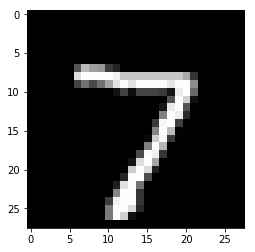

Model prediction: 7


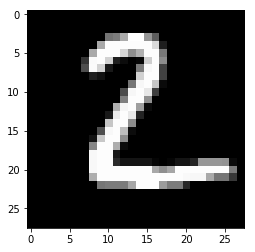

Model prediction: 2


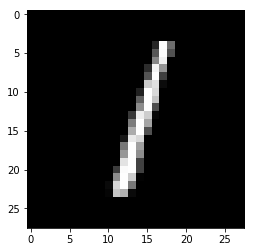

Model prediction: 1


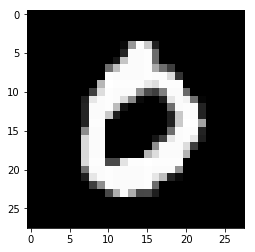

Model prediction: 0


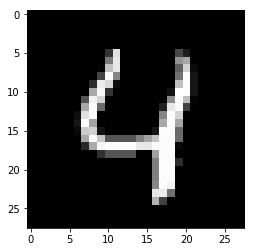

Model prediction: 4


In [11]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Red neuronal convolucional (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a>
</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a></td>
</table>

En este tutorial se muestra el entrenamiento de una sencilla [Red neuronal convolucional](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) para clasificar [imágenes CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html). Dado que este tutorial utiliza la [API secuencial de Keras](https://www.tensorflow.org/guide/keras/overview), crear y entrenar su modelo le llevará tan solo unas pocas líneas de código.


### Importar TensorFlow

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Descargue y prepare el conjunto de datos CIFAR10

El conjunto de datos CIFAR10 contiene 60,000 imágenes en color en 10 clases, con 6,000 imágenes en cada clase. El conjunto de datos se divide en 50,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Las clases son mutuamente excluyentes y no hay superposición entre ellas.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verifique los datos

Para verificar que el conjunto de datos parece correcto, vamos a representar las 25 primeras imágenes del conjunto de entrenamiento y a mostrar el nombre de la clase debajo de cada imagen:


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Cree la base convolucional

Las 6 líneas de código siguientes definen la base convolucional utilizando un patrón común: una pila de capas [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) y [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

Como entrada, una CNN toma tensores de forma (image_height, image_width, color_channels), ignorando el tamaño del lote. Si no conoce estas dimensiones, color_channels se refiere a (R,G,B). En este ejemplo, configurará su CNN para procesar entradas de forma (32, 32, 3), que es el formato de las imágenes CIFAR. Puede hacerlo pasando el argumento `input_shape` a su primera capa.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Visualicemos la arquitectura de su modelo hasta ahora:

In [ ]:
model.summary()

Arriba, puede ver que la salida de cada capa Conv2D y MaxPooling2D es un tensor 3D de forma (altura, ancho, canales). Las dimensiones de ancho y altura tienden a reducirse conforme se profundiza en la red. El número de canales de salida de cada capa Conv2D se controla mediante el primer argumento (por ejemplo, 32 o 64). Normalmente, cuando el ancho y la altura se encogen, puede permitirse (computacionalmente) agregar más canales de salida en cada capa Conv2D.

### Agregue capas densas en la parte superior

Para completar el modelo, introducirá el último tensor de salida de la base convolucional (de forma (4, 4, 64)) en una o varias capas densas para realizar la clasificación. Las capas densas toman vectores como entrada (que son 1D), mientras que la salida actual es un tensor 3D. Primero, aplanará (o desenrollará) la salida 3D a 1D, y después agregará una o más capas Densas en la parte superior. CIFAR tiene 10 clases de salida, por lo que utilizará una capa Densa final con 10 salidas.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Esta es la arquitectura completa de su modelo:

In [ ]:
model.summary()

El resumen de la red muestra que las salidas (4, 4, 64) se aplanaron en vectores de forma (1024) antes de pasar por dos capas densas.

### Compile y entrene el modelo

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

### Evaluación del modelo

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

Su CNN simple ha logrado una precisión en las pruebas de más del 70%. ¡No está mal para unas pocas líneas de código! Para otro estilo de CNN, eche un vistazo al ejemplo [TensorFlow 2 quickstart para expertos](https://www.tensorflow.org/tutorials/quickstart/advanced) que utiliza la API de subclases de Keras y `tf.GradientTape`.

# Multi-GPU Training Example

Train a convolutional neural network on multiple GPU with TensorFlow 2.0+.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## Training with multiple GPU cards

In this example, we are using data parallelism to split the training accross multiple GPUs. Each GPU has a full replica of the neural network model, and the weights (i.e. variables) are updated synchronously by waiting that each GPU process its batch of data.

First, each GPU process a distinct batch of data and compute the corresponding gradients, then, all gradients are accumulated in the CPU and averaged. The model weights are finally updated with the gradients averaged, and the new model weights are sent back to each GPU, to repeat the training process.

<img src="https://www.tensorflow.org/images/Parallelism.png" alt="Parallelism" style="width: 400px;"/>

## CIFAR10 Dataset Overview

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

![CIFAR10 Dataset](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

More info: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import time
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_gpus = 4

# Training parameters.
learning_rate = 0.001
training_steps = 1000
# Split batch size equally between GPUs.
# Note: Reduce batch size if you encounter OOM Errors.
batch_size = 1024 * num_gpus
display_step = 20

# Network parameters.
conv1_filters = 64 # number of filters for 1st conv layer.
conv2_filters = 128 # number of filters for 2nd conv layer.
conv3_filters = 256 # number of filters for 2nd conv layer.
fc1_units = 2048 # number of neurons for 1st fully-connected layer.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.
y_train, y_test = np.reshape(y_train, (-1)), np.reshape(y_test, (-1))

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(batch_size * 10).batch(batch_size).prefetch(num_gpus)

In [5]:
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv1_1 = layers.Conv2D(conv1_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        self.conv1_2 = layers.Conv2D(conv1_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 128 filters and a kernel size of 3.
        self.conv2_1 = layers.Conv2D(conv2_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        self.conv2_2 = layers.Conv2D(conv2_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        self.conv2_3 = layers.Conv2D(conv2_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 256 filters and a kernel size of 3.
        self.conv3_1 = layers.Conv2D(conv3_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        self.conv3_2 = layers.Conv2D(conv3_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)
        self.conv3_3 = layers.Conv2D(conv3_filters, kernel_size=3, padding='SAME', activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    @tf.function
    def call(self, x, is_training=False):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.maxpool1(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        x = self.maxpool2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

In [6]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
@tf.function
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
@tf.function
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)
    

@tf.function
def backprop(batch_x, batch_y, trainable_variables):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(batch_x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, batch_y)
        # Compute gradients.
        gradients = g.gradient(loss, trainable_variables)
    return gradients

# Build the function to average the gradients.
@tf.function
def average_gradients(tower_grads):
    avg_grads = []
    for tgrads in zip(*tower_grads):
        grads = []
        for g in tgrads:
            expanded_g = tf.expand_dims(g, 0)
            grads.append(expanded_g)
        
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)
        
        avg_grads.append(grad)
        
    return avg_grads

In [7]:
with tf.device('/cpu:0'):
    # Build convnet.
    conv_net = ConvNet()
    # Stochastic gradient descent optimizer.
    optimizer = tf.optimizers.Adam(learning_rate)

In [8]:
# Optimization process.
def run_optimization(x, y):
    # Save gradients for all GPUs.
    tower_grads = []
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    with tf.device('/cpu:0'):
        for i in range(num_gpus):
            # Split data between GPUs.
            gpu_batch_size = int(batch_size/num_gpus)
            batch_x = x[i * gpu_batch_size: (i+1) * gpu_batch_size]
            batch_y = y[i * gpu_batch_size: (i+1) * gpu_batch_size]
            
            # Build the neural net on each GPU.
            with tf.device('/gpu:%i' % i):
                grad = backprop(batch_x, batch_y, trainable_variables)
                tower_grads.append(grad)
                    
                # Last GPU Average gradients from all GPUs.
                if i == num_gpus - 1:
                    gradients = average_gradients(tower_grads)

        # Update vars following gradients.
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [9]:
# Run training for the given number of steps.
ts = time.time()
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0 or step == 1:
        dt = time.time() - ts
        speed = batch_size * display_step / dt
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f, speed: %f examples/sec" % (step, loss, acc, speed))
        ts = time.time()

step: 1, loss: 2.302630, accuracy: 0.101318, speed: 16342.138481 examples/sec
step: 20, loss: 2.296755, accuracy: 0.108398, speed: 5355.197204 examples/sec
step: 40, loss: 2.216037, accuracy: 0.299072, speed: 12388.080848 examples/sec
step: 60, loss: 2.189814, accuracy: 0.362305, speed: 12033.404638 examples/sec
step: 80, loss: 2.137831, accuracy: 0.410156, speed: 12189.852065 examples/sec
step: 100, loss: 2.102876, accuracy: 0.437744, speed: 12212.349483 examples/sec
step: 120, loss: 2.077521, accuracy: 0.460693, speed: 12160.290400 examples/sec
step: 140, loss: 2.006775, accuracy: 0.545166, speed: 12202.175380 examples/sec
step: 160, loss: 1.994143, accuracy: 0.554443, speed: 12168.070368 examples/sec
step: 180, loss: 1.964281, accuracy: 0.597412, speed: 12244.148312 examples/sec
step: 200, loss: 1.893395, accuracy: 0.658203, speed: 12197.382402 examples/sec
step: 220, loss: 1.880256, accuracy: 0.672363, speed: 12178.323620 examples/sec
step: 240, loss: 1.868853, accuracy: 0.676025, 

##### Copyright 2019 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Entrenamiento distribuido con Keras

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/distribute/keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/distribute/keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a>
</td>
</table>

## Descripción general

La API `tf.distribute.Strategy` ofrece una abstracción para distribuir su entrenamiento entre varias unidades de procesamiento. Permite realizar un entrenamiento distribuido usando los modelos y el código de entrenamiento existentes con cambios mínimos.

Este tutorial muestra cómo usar `tf.distribute.MirroredStrategy` para implementar la replicación dentro del grafo con *entrenamiento síncrono en muchas GPU de una misma máquina*. Esencialmente, la estrategia copia todas las variables del modelo en cada procesador. Luego usa [all-reduce](http://mpitutorial.com/tutorials/mpi-reduce-and-allreduce/) para combinar los gradientes de todos los procesadores y aplica el valor combinado a todas las copias del modelo.

Usará las API de `tf.keras` API para construir el modelo y `Model.fit` para entrenarlo (si quiere aprender sobre la capacitación distribuida con un bucle de entrenamiento personalizado y el `MirroredStrategy`, consulte [este tutorial](custom_training.ipynb)).

`MirroredStrategy` entrene su modelo en varias GPU de una sola máquina. Para *entrenamiento síncrono en muchas GPUs en múltiples trabajadores*, usa el `tf.distribute.MultiWorkerMirroredStrategy` con el [Keras Model.fit](multi_worker_with_keras.ipynb) o [un bucle de capacitación personalizado](multi_worker_with_ctl.ipynb). Para otras opciones, refiérete a la [Guía de entrenamiento distribuido](../../guide/distributed_training.ipynb).

Para conocer otras estrategias, consulte la guía [Entrenamiento distribuido con TensorFlow](../../guide/distributed_training.ipynb).

## Preparación

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import os

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
print(tf.__version__)

## Descargar el conjunto de datos

Cargue el conjunto de datos MNIST de [Conjuntos de datos TensorFlow](https://www.tensorflow.org/datasets). Esto devuelve un conjunto de datos en formato `tf.data`.

Si establece el argumento `con_info` en `True`, se incluirán los metadatos de todo el conjunto de datos, que se almacenan aquí en `info`. Este objeto de metadatos incluye, entre otras cosas, el número de ejemplos de entrenamiento y de prueba.

In [ ]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

## Definir la estrategia de distribución

Crea un objeto `MirroredStrategy`. Se encargará de la distribución y creará un gestor de contexto (`MirroredStrategy.scope`) en el que construir tu modelo.

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

## Configurar la canalización de entrada

Si está entrenando un modelo con varias GPU, puedes usar eficazmente la potencia de procesamiento adicional aumentando el tamaño del lote. Por lo general, debes usar el tamaño de lote más grande que quepa en la memoria de la GPU y ajustar la tasa de aprendizaje en consecuencia.

In [ ]:
# You can also do info.splits.total_num_examples to get the total
# number of examples in the dataset.

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

Define una función que normalice los valores de los pixeles de imagen que van de `[0, 255]` a `[0, 1]` ([escalado de características](https://en.wikipedia.org/wiki/Feature_scaling)):

In [ ]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

Aplica esta función `scale` a los datos de entrenamiento y de prueba, y luego usa las APIs `tf.data.Dataset` para mezclar los datos de entrenamiento (`Dataset.shuffle`) y procesarlos por lotes (`Dataset.batch`). Recuerda conservar también una caché en memoria de los datos de entrenamiento para mejorar el rendimiento (`Dataset.cache`).

In [ ]:
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

## Crear el modelo e instanciar el optimizador

En el contexto de `Strategy.scope`, crea y compila el modelo usando la API Keras:

In [ ]:
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

Para este ejemplo ficticio con el conjunto de datos MNIST, usará la tasa de aprendizaje predeterminada del optimizador Adam de 0.001.

Para conjuntos de datos más grandes, el beneficio clave del entrenamiento distribuido es aprender más en cada paso del entrenamiento, porque cada paso procesa más datos de entrenamiento en paralelo, lo que permite una mayor tasa de aprendizaje (dentro de los límites del modelo y del conjunto de datos).

## Definir las retrollamadas


Define los siguientes [retrollamadas Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate):

- `tf.keras.callbacks.TensorBoard`: escribe un log para TensorBoard, que te permite visualizar los grafos.
- `tf.keras.callbacks.ModelCheckpoint`: guarda el modelo con cierta frecuencia, por ejemplo, después de cada época.
- `tf.keras.callbacks.BackupAndRestore`: añade la funcionalidad de tolerancia a fallos haciendo una copia de seguridad del modelo y del número de época actual. Para más información, consulta la sección *Tolerancia a fallos* del tutorial [Entrenamiento multitrabajador con Keras](multi_worker_with_keras.ipynb).
- `tf.keras.callbacks.LearningRateScheduler`: planifica el cambio del ritmo de aprendizaje después de, por ejemplo, cada época/lote.

Para ilustrarlo, añade una [retrollamada personalizada](https://www.tensorflow.org/guide/keras/custom_callback) denominada `PrintLR` para mostrar la *velocidad de aprendizaje* en el bloc de notas.

**Nota:** Usa la retrollamada `BackupAndRestore` en lugar de `ModelCheckpoint` como mecanismo principal para restaurar el estado del entrenamiento cuando falle un trabajo. Como `BackupAndRestore` sólo funciona en eager mode, considera usar `ModelCheckpoint` en modo de grafo.

In [ ]:
# Define the checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
# Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
# Define a function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [ ]:
# Define a callback for printing the learning rate at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(        epoch + 1, model.optimizer.lr.numpy()))

In [ ]:
# Put all the callbacks together.
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

## Entrenar y evaluar

Ahora, entrena el modelo del modo habitual llamando a `Model.fit` de Keras en el modelo y pasándole el conjunto de datos creado al principio del tutorial. Este paso es el mismo tanto si distribuyes el entrenamiento como si no.

In [ ]:
EPOCHS = 12

model.fit(train_dataset, epochs=EPOCHS, callbacks=callbacks)

Busca puntos de verificación guardados:

In [ ]:
# Check the checkpoint directory.
!ls {checkpoint_dir}

Carga el último punto de verificación y llama a `Model.evaluate` con los datos de prueba para ver el rendimiento del modelo:

In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

eval_loss, eval_acc = model.evaluate(eval_dataset)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

Para visualizar el resultado, inicia TensorBoard y mira los logs:

In [ ]:
%tensorboard --logdir=logs

<!-- <img class="tfo-display-only-on-site" src="images/tensorboard_distributed_training_with_keras.png"/> -->

In [ ]:
!ls -sh ./logs

## Guardar el modelo

Guarda el modelo en un archivo zip `.keras` usando `Model.save`. Cuando tengas el modelo guardado, puedes cargarlo con o sin el `Strategy.scope`.

In [ ]:
path = 'my_model.keras'

In [ ]:
model.save(path)

Ahora carga el modelo sin `Strategy.scope`:

In [ ]:
unreplicated_model = tf.keras.models.load_model(path)

unreplicated_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

eval_loss, eval_acc = unreplicated_model.evaluate(eval_dataset)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

Carga el modelo con `Strategy.scope`:

In [ ]:
with strategy.scope():
  replicated_model = tf.keras.models.load_model(path)
  replicated_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

  eval_loss, eval_acc = replicated_model.evaluate(eval_dataset)
  print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

### Recursos adicionales

Más ejemplos que usan diferentes estrategias de distribución con la API `Model.fit` de Keras:

1. El tutorial [Resolver tareas GLUE utilizando BERT en TPU](https://www.tensorflow.org/text/tutorials/bert_glue) usa `tf.distribute.MirroredStrategy` para entrenar en GPUs y `tf.distribute.TPUStrategy` en TPUs.
2. El tutorial [Guardar y cargar un modelo mediante una estrategia de distribución](save_and_load.ipynb) muestra cómo usar las API SavedModel con `tf.distribute.Strategy`.
3. Los [modelos oficiales de TensorFlow](https://github.com/tensorflow/models/tree/master/official) pueden configurarse para ejecutar múltiples estrategias de distribución.

Para saber más sobre las estrategias de distribución de TensorFlow:

1. El tutorial [Entrenamiento personalizado con tf.distribute.Strategy](custom_training.ipynb) enseña a usar `tf.distribute.MirroredStrategy` para entrenar a un solo trabajador con un bucle de entrenamiento personalizado.
2. El tutorial [Entrenamiento multitrabajador con Keras](multi_worker_with_keras.ipynb) enseña a usar la `MultiWorkerMirroredStrategy` con `Model.fit`.
3. El tutorial [Bucle de entrenamiento personalizado con Keras y MultiWorkerMirroredStrategy](multi_worker_with_ctl.ipynb) muestra cómo usar la `MultiWorkerMirroredStrategy` con Keras y un bucle de entrenamiento personalizado.
4. La guía [Entrenamiento distribuido en TensorFlow](https://www.tensorflow.org/guide/distributed_training) da una visión general de las estrategias de distribución disponibles.
5. La guía [Mejor rendimiento con tf.function](../../guide/function.ipynb) ofrece información sobre otras estrategias y herramientas, como el [Perfilador TensorFlow](../../guide/profiler.md) que puedes usar para optimizar el rendimiento de tus modelos TensorFlow.

Nota: `tf.distribute.Strategy` se encuentra activamente en desarrollo y TensorFlow añadirá más ejemplos y tutoriales en un futuro próximo. Anímate a probarlo. Tu retroalimentación es bienvenida, no dudes en enviarla a través de [issues en GitHub](https://github.com/tensorflow/tensorflow/issues/new).

# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

## Load and explore the data

Begin by taking a look at some images of the dataset.

Notice that all the images are contained within the `./data/` directory. 

This directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to.

Sample happy image:


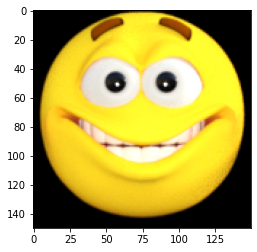


Sample sad image:


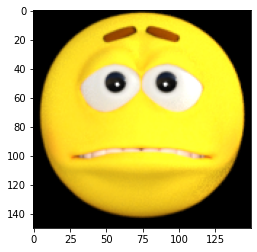

In [2]:
from tensorflow.keras.preprocessing.image import load_img

base_dir = "./data/"
happy_dir = os.path.join(base_dir, "happy/")
sad_dir = os.path.join(base_dir, "sad/")

print("Sample happy image:")
plt.imshow(load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
plt.show()

print("\nSample sad image:")
plt.imshow(load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
plt.show()


It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use Keras as shown in the next cell:

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB channels that are used to represent colored images.**

## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

A quick note on callbacks: 

So far you have used only the `on_epoch_end` callback but there are many more. For example you might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which allows you to save the best weights for your model.

## Pre-processing the data

Keras provides great support for preprocessing image data. A lot can be accomplished by using the `ImageDataGenerator` class. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) if you get stuck in the next exercise. In particular you might want to pay attention to the `rescale` argument when instantiating the `ImageDataGenerator` and to the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# GRADED FUNCTION: image_generator
def image_generator():
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class.
    # Remember to set the rescale argument.
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = train_datagen.flow_from_directory(directory=base_dir,
                                                        target_size=(150, 150),
                                                        batch_size=10,
                                                        class_mode='binary')
    ### END CODE HERE

    return train_generator
    

In [6]:
# Save your generator in a variable
gen = image_generator()

Found 80 images belonging to 2 classes.


**Expected Output:**
```
Found 80 images belonging to 2 classes.
```

## Creating and training your model

Finally, complete the `train_happy_sad_model` function below. This function should return your  neural network.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers. 


- In case you need extra help you can check out some tips at the end of this notebook.

In [26]:
from tensorflow.keras import optimizers, losses
# GRADED FUNCTION: train_happy_sad_model
def train_happy_sad_model(train_generator):

    # Instantiate the callback
    callbacks = myCallback()

    ### START CODE HERE

    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), input_shape=(150, 150, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    # Select a loss function compatible with the last layer of your network
    model.compile(loss='binary_crossentropy',
                  optimizer= optimizers.RMSprop(learning_rate=0.001),
                  metrics=['accuracy']) 
    


    # Train the model
    # Your model should achieve the desired accuracy in less than 15 epochs.
    # You can hardcode up to 20 epochs in the function below but the callback should trigger before 15.
    history = model.fit(x=train_generator,
                        epochs=15,
                        callbacks=[callbacks]
                       ) 
    
    ### END CODE HERE
    return history

In [28]:
hist = train_happy_sad_model(gen)

Epoch 1/15
8/8 [==============================] - 10s 1s/step - loss: 3.6750 - accuracy: 0.6125
Epoch 2/15
8/8 [==============================] - 8s 1s/step - loss: 0.2696 - accuracy: 0.8375
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.0954 - accuracy: 0.9750
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.3901 - accuracy: 0.8625
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.0726 - accuracy: 0.9875
Epoch 6/15
8/8 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000
Reached 99.9% accuracy so cancelling training!
8/8 [==============================] - 9s 1s/step - loss: 0.0216 - accuracy: 1.0000


If you see the message that was defined in the callback printed out after less than 15 epochs it means your callback worked as expected and training was successful. You can also double check by running the following cell:

In [17]:
print(f"Your model reached the desired accuracy after {len(hist.epoch)} epochs")

Your model reached the desired accuracy after 15 epochs


## Need more help?

Run the following cell to see some extra tips for the model's architecture.

In [29]:
import base64

encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIEEgZ29vZCBmaXJzdCBsYXllciB3b3VsZCBiZSBhIENvbnYyRCBsYXllciB3aXRoIGFuIGlucHV0IHNoYXBlIHRoYXQgbWF0Y2hlcyAKICAgIHRoYXQgb2YgZXZlcnkgaW1hZ2UgaW4gdGhlIHRyYWluaW5nIHNldCAoaW5jbHVkaW5nIHRoZSBjb2xvciBkaW1lbnNpb24pCiAgICAKICAgIC0gVGhlIG1vZGVsIHdpbGwgd29yayBiZXN0IHdpdGggMyBjb252b2x1dGlvbmFsIGxheWVycwogICAgCiAgICAtIFRoZXJlIHNob3VsZCBiZSBhIEZsYXR0ZW4gbGF5ZXIgaW4gYmV0d2VlbiBjb252b2x1dGlvbmFsIGFuZCBkZW5zZSBsYXllcnMKICAgIAogICAgLSBUaGUgZmluYWwgbGF5ZXIgc2hvdWxkIGJlIGEgRGVuc2UgbGF5ZXIgd2l0aCB0aGUgbnVtYmVyIG9mIHVuaXRzIGFuZCAKICAgIGFjdGl2YXRpb24gZnVuY3Rpb24gdGhhdCBzdXBwb3J0cyBiaW5hcnkgY2xhc3NpZmljYXRpb24uCg=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


Some helpful tips in case you are stuck:

    - A good first layer would be a Conv2D layer with an input shape that matches 
    that of every image in the training set (including the color dimension)
    
    - The model will work best with 3 convolutional layers
    
    - There should be a Flatten layer in between convolutional and dense layers
    
    - The final layer should be a Dense layer with the number of units and 
    activation function that supports binary classification.



**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_1_image_generator_no_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training with ImageDataGenerator

In this lab, you will build a train a model on the [Horses or Humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset. This contains over a thousand images of horses and humans with varying poses and filesizes. You will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to prepare this dataset so it can be fed to a convolutional neural network.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

Run the code below to download the compressed dataset `horse-or-human.zip`.

In [ ]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

You can then unzip the archive using the [zipfile](https://docs.python.org/3/library/zipfile.html) module.

In [ ]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory `./horse-or-human`, which in turn each contain `horses` and `humans` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like' and 'this is what a human looks like'.

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. You will use the ImageDataGenerator API instead -- and this is coded to automatically label images according to the directory names and structure. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. `ImageDataGenerator` will label the images appropriately for you, reducing a coding step. 

You can now define each of these directories:

In [ ]:
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

Now see what the filenames look like in the `horses` and `humans` training directories:

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

You can also find out the total number of horse and human images in the directories:

In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

Now you can define the model architecture that you will train.

Step 1 will be to import tensorflow.

In [ ]:
import tensorflow as tf

You then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers. Note that because this is a two-class classification problem, i.e. a *binary classification problem*, you will end your network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). This makes the output value of your network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can review the network architecture and the output shapes with `model.summary()`.

In [ ]:
model.summary()

The "output shape" column shows how the size of your feature map evolves in each successive layer. As you saw in an earlier lesson, the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. You will train the model with the [`binary_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss because it's a binary classification problem, and the final activation is a sigmoid. (For a refresher on loss metrics, see this [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) You will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, you will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Next step is to set up the data generators that will read pictures in the source folders, convert them to `float32` tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras, this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


### Training

You can start training for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses. 

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

**Important Note:** Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a `Colab` on the `Safari` browser. For all other browsers, continue with the next code block and ignore the next one after it.

_For Safari users: please comment out or skip the code block below, uncomment the next code block and run it._

In [ ]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

`Safari` users will need to upload the images(s) manually in their workspace. Please follow the instructions, uncomment the code block below and run it.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [ ]:
# # CODE BLOCK FOR SAFARI USERS

# import numpy as np
# from keras.preprocessing import image
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = image.load_img(path, target_size=(300, 300))
#  x = image.img_to_array(img)
#  x /= 255
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a human")
#  else:
#    print(i + " is a horse")

### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid. 

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

## Clean Up

You will continue with a similar exercise in the next lab but before that, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_3_compacted_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Effect of Compacted Images in Training

In this notebook, you will see how reducing the target size of the generator images will affect the architecture and performance of your model. This is a useful technique in case you need to speed up your training or save compute resources. Let's begin!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

As before, start downloading the train and validation sets:

In [ ]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

In [ ]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

Then unzip them:

In [ ]:
import zipfile

# Unzip training set
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')

# Unzip validation set
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

Then define the directories containing the images:

In [ ]:
import os

# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

You can check that the directories are not empty and that the train set has more images than the validation set:

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

In [ ]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

## Build the Model

The model will follow the same architecture as before but they key difference is in the `input_shape` parameter of the first `Conv2D` layer. Since you will be compacting the images later in the generator, you need to specify the expected image size here. So instead of 300x300 as in the previous two labs, you specify a smaller 150x150 array.

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution (You can uncomment the 4th and 5th conv layers later to see the effect)
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fifth convolution
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can see the difference from previous models when you print the `model.summary()`. As expected, there will be less inputs to the `Dense` layer at the end of the model compared to the previous labs. This is because you used the same number of max pooling layers in your model. And since you have a smaller image to begin with (150 x 150), then the output after all the pooling layers will also be smaller.

In [ ]:
model.summary()

You will use the same settings for training:

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will instantiate the data generators. As mentioned before, you will be compacting the image by specifying the `target_size` parameter. See the simple change below:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since you used binary_crossentropy loss, you need binary labels
        class_mode='binary')

### Training

Now you're ready to train and see the results. Note your observations about how fast the model trains and the accuracies you're getting in the train and validation sets.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

### Model Prediction

As usual, it is also good practice to try running your model over some handpicked images. See if you got better, worse, or the same performance as the previous lab.

**Important Note:** Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a `Colab` on the `Safari` browser. For all other browsers, continue with the next code block and ignore the next one after it.

_For Safari users: please comment out or skip the code block below, uncomment the next code block and run it._

In [ ]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

`Safari` users will need to upload the images(s) manually in their workspace. Please follow the instructions, uncomment the code block below and run it.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [ ]:
# # CODE BLOCK FOR SAFARI USERS

# import numpy as np
# from keras.preprocessing import image
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = image.load_img(path, target_size=(150, 150))
#  x = image.img_to_array(img)
#  x /= 255
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a human")
#  else:
#    print(i + " is a horse")

### Visualizing Intermediate Representations

You can also look again at the intermediate representations. You will notice that the output at the last convolution layer is even more abstract because it contains fewer pixels than before.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean Up

Please run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

## Wrap Up

In this lab, you saw how compacting images affected your previous model. This is one technique to keep in mind especially when you are still in the exploratory phase of your own projects. You can see if a smaller model behaves just as well as a large model so you can have faster training. You also saw how easy it is to customize your images for this adjustment in size by simply changing a parameter in the `ImageDataGenerator` class.

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W4/ungraded_labs/C1_W4_Lab_2_image_generator_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: ImageDataGenerator with a Validation Set

In this lab, you will continue using the `ImageDataGenerator` class to prepare the `Horses or Humans` dataset. This time, you will add a validation set so you can also measure how well the model performs on data it hasn't seen.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

Run the code blocks below to download the datasets `horse-or-human.zip` and `validation-horse-or-human.zip` respectively.

In [ ]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

In [ ]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

Then unzip both archives.

In [ ]:
import zipfile

# Unzip training set
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')

# Unzip validation set
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

Similar to the previous lab, you will define the directories containing your images. This time, you will include those with validation data.

In [ ]:
import os

# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

Now see what the filenames look like in these directories:

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_names = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_names[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

You can find out the total number of horse and human images in the directories:

In [ ]:
print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}')
print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 horse and 8 human pictures. You can rerun the cell to see a fresh batch each time:

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

You will define the same model architecture as before:

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You can review the network architecture and the output shapes with `model.summary()`.

In [ ]:
model.summary()

You will also use the same compile settings as before:

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Now you will setup the data generators. It will mostly be the same as last time but notice the additional code to also prepare the validation data. It will need to be instantiated separately and also scaled to have `[0,1]` range of pixel values.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')

# Flow validation images in batches of 128 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './validation-horse-or-human/',  # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')

### Training
Now train the model for 15 epochs. Here, you will pass parameters for `validation_data` and `validation_steps`. With these, you will notice additional outputs in the print statements: `val_loss` and `val_accuracy`. Notice that as you train with more epochs, your training accuracy might go up but your validation accuracy goes down. This can be a sign of overfitting and you need to prevent your model from reaching this point.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

**Important Note:** Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a `Colab` on the `Safari` browser. For all other browsers, continue with the next code block and ignore the next one after it.

_For Safari users: please comment out or skip the code block below, uncomment the next code block and run it._

In [ ]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

`Safari` users will need to upload the images(s) manually in their workspace. Please follow the instructions, uncomment the code block below and run it.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [ ]:
# # CODE BLOCK FOR SAFARI USERS

# import numpy as np
# from keras.preprocessing import image
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = image.load_img(path, target_size=(300, 300))
#  x = image.img_to_array(img)
#  x /= 255
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a human")
#  else:
#    print(i + " is a horse")

### Visualizing Intermediate Representations

As before, you can plot how the features are transformed as it goes through each layer.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

# Week 3: Improve MNIST with Convolutions

In the videos you looked at how you would improve Fashion MNIST using Convolutions. For this exercise see if you can improve MNIST to 99.5% accuracy or more by adding only a single convolutional layer and a single MaxPooling 2D layer to the model from the  assignment of the previous week. 

You should stop training once the accuracy goes above this amount. It should happen in less than 10 epochs, so it's ok to hard code the number of epochs for training, but your training must end once it hits the above metric. If it doesn't, then you'll need to redesign your callback.

When 99.5% accuracy has been hit, you should print out the string "Reached 99.5% accuracy so cancelling training!"


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

## Load the data

Begin by loading the data. A couple of things to notice:

- The file `mnist.npz` is already included in the current workspace under the `data` directory. By default the `load_data` from Keras accepts a path relative to `~/.keras/datasets` but in this case it is stored somewhere else, as a result of this, you need to specify the full path.

- `load_data` returns the train and test sets in the form of the tuples `(x_train, y_train), (x_test, y_test)` but in this exercise you will be needing only the train set so you can ignore the second tuple.

In [2]:
# Load the data

# Get current working directory
current_dir = os.getcwd() 

# Append data/mnist.npz to the previous path to get the full path
data_path = os.path.join(current_dir, "data/mnist.npz") 

# Get only training set
(training_images, training_labels), _ = tf.keras.datasets.mnist.load_data(path=data_path) 

## Pre-processing the data

One important step when dealing with image data is to preprocess the data. During the preprocess step you can apply transformations to the dataset that will be fed into your convolutional neural network.

Here you will apply two transformations to the data:
- Reshape the data so that it has an extra dimension. The reason for this 
is that commonly you will use 3-dimensional arrays (without counting the batch dimension) to represent image data. The third dimension represents the color using RGB values. This data might be in black and white format so the third dimension doesn't really add any additional information for the classification process but it is a good practice regardless.


- Normalize the pixel values so that these are values between 0 and 1. You can achieve this by dividing every value in the array by the maximum.

Remember that these tensors are of type `numpy.ndarray` so you can use functions like [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) or [divide](https://numpy.org/doc/stable/reference/generated/numpy.divide.html) to complete the `reshape_and_normalize` function below:

In [7]:
# GRADED FUNCTION: reshape_and_normalize

def reshape_and_normalize(images):
    
    ### START CODE HERE

    # Reshape the images to add an extra dimension
    images = images.reshape((images.shape + (1,)))
    
    # Normalize pixel values
    images = images / np.max(images)
    
    ### END CODE HERE

    return images

Test your function with the next cell:

In [8]:
# Reload the images in case you run this cell multiple times
(training_images, _), _ = tf.keras.datasets.mnist.load_data(path=data_path) 

# Apply your function
training_images = reshape_and_normalize(training_images)

print(f"Maximum pixel value after normalization: {np.max(training_images)}\n")
print(f"Shape of training set after reshaping: {training_images.shape}\n")
print(f"Shape of one image after reshaping: {training_images[0].shape}")


Maximum pixel value after normalization: 1.0

Shape of training set after reshaping: (60000, 28, 28, 1)

Shape of one image after reshaping: (28, 28, 1)


**Expected Output:**
```
Maximum pixel value after normalization: 1.0

Shape of training set after reshaping: (60000, 28, 28, 1)

Shape of one image after reshaping: (28, 28, 1)
```

## Defining your callback

Now complete the callback that will ensure that training will stop after an accuracy of 99.5% is reached:

In [19]:
# GRADED CLASS: myCallback
### START CODE HERE

# Remember to inherit from the correct class
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if 'accuracy' in logs and logs['accuracy'] >= 0.995:
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

### END CODE HERE


## Convolutional Model

Finally, complete the `convolutional_model` function below. This function should return your convolutional neural network.

**Your model should achieve an accuracy of 99.5% or more before 10 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but try to keep in mind you don't need a complex one. For instance, only one convolutional layer is needed. 

- In case you need extra help you can check out an architecture that works pretty well at the end of this notebook.

In [20]:
# GRADED FUNCTION: convolutional_model
def convolutional_model():
    ### START CODE HERE

    # Define the model
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    ### END CODE HERE

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
        
    return model

In [21]:
# Save your untrained model
model = convolutional_model()

# Instantiate the callback class
callbacks = myCallback()

# Train your model (this can take up to 5 minutes)
history = model.fit(training_images, training_labels, epochs=10, callbacks=[callbacks])

Epoch 1/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1736 - accuracy: 0.9512
Epoch 2/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0470 - accuracy: 0.9857
Epoch 3/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.0324 - accuracy: 0.9902
Epoch 4/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.0231 - accuracy: 0.9931
Epoch 5/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0179 - accuracy: 0.9948
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9959
Reached 99.5% accuracy so cancelling training!
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0131 - accuracy: 0.9959


If you see the message that you defined in your callback printed out after less than 10 epochs it means your callback worked as expected. You can also double check by running the following cell:

In [22]:
print(f"Your model was trained for {len(history.epoch)} epochs")

Your model was trained for 6 epochs


## Need more help?

Run the following cell to see an architecture that works well for the problem at hand:

In [23]:
# WE STRONGLY RECOMMEND YOU TO TRY YOUR OWN ARCHITECTURES FIRST
# AND ONLY RUN THIS CELL IF YOU WISH TO SEE AN ANSWER

import base64

encoded_answer = "CiAgIC0gQSBDb252MkQgbGF5ZXIgd2l0aCAzMiBmaWx0ZXJzLCBhIGtlcm5lbF9zaXplIG9mIDN4MywgUmVMVSBhY3RpdmF0aW9uIGZ1bmN0aW9uIGFuZCBhbiBpbnB1dCBzaGFwZSB0aGF0IG1hdGNoZXMgdGhhdCBvZiBldmVyeSBpbWFnZSBpbiB0aGUgdHJhaW5pbmcgc2V0CiAgIC0gQSBNYXhQb29saW5nMkQgbGF5ZXIgd2l0aCBhIHBvb2xfc2l6ZSBvZiAyeDIKICAgLSBBIEZsYXR0ZW4gbGF5ZXIgd2l0aCBubyBhcmd1bWVudHMKICAgLSBBIERlbnNlIGxheWVyIHdpdGggMTI4IHVuaXRzIGFuZCBSZUxVIGFjdGl2YXRpb24gZnVuY3Rpb24KICAgLSBBIERlbnNlIGxheWVyIHdpdGggMTAgdW5pdHMgYW5kIHNvZnRtYXggYWN0aXZhdGlvbiBmdW5jdGlvbgo="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


   - A Conv2D layer with 32 filters, a kernel_size of 3x3, ReLU activation function and an input shape that matches that of every image in the training set
   - A MaxPooling2D layer with a pool_size of 2x2
   - A Flatten layer with no arguments
   - A Dense layer with 128 units and ReLU activation function
   - A Dense layer with 10 units and softmax activation function



**Congratulations on finishing this week's assignment!**

You have successfully implemented a CNN to assist you in the image classification task. Nice job!

**Keep it up!**

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W3/ungraded_labs/C1_W3_Lab_1_improving_accuracy_using_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Improving Computer Vision Accuracy using Convolutions





# Shallow Neural Network

In the previous lessons, you saw how to do fashion recognition using a neural network containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and only one hidden layer. You experimented with the impact of different sizes of hidden layer, number of training epochs etc on the final accuracy. For convenience, here's the entire code again. Run it and take a note of the test accuracy that is printed out at the end. 

In [ ]:
import tensorflow as tf

# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

# Normalize the pixel values
training_images = training_images / 255.0
test_images = test_images / 255.0

In [ ]:


# Define the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Setup training parameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print(f'\nMODEL TRAINING:')
model.fit(training_images, training_labels, epochs=5)

# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(test_images, test_labels)

## Convolutional Neural Network

In the model above, your accuracy will probably be about 89% on training and 87% on validation. Not bad. But how do you make that even better? One way is to use something called _convolutions_. We're not going into the details of convolutions in this notebook (please see resources in the classroom), but the ultimate concept is that they narrow down the content of the image to focus on specific parts and this will likely improve the model accuracy. 

If you've ever done image processing using a filter (like [this](https://en.wikipedia.org/wiki/Kernel_(image_processing))), then convolutions will look very familiar. In short, you take an array (usually 3x3 or 5x5) and scan it over the entire image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 matrix that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision because it often highlights features that distinguish one item from another. Moreover, the amount of information needed is then much less because you'll just train on the highlighted features.

That's the concept of **Convolutional Neural Networks**. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focused and possibly more accurate.

Run the code below. This is the same neural network as earlier, but this time with [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers added first. It will take longer, but look at the impact on the accuracy.

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
                                                         
  # Add convolutions and max pooling
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  # Add the same layers as before
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Print the model summary
model.summary()

# Use same settings
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print(f'\nMODEL TRAINING:')
model.fit(training_images, training_labels, epochs=5)

# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(test_images, test_labels)


It's likely gone up to about 92% on the training data and 90% on the validation data. That's significant, and a step in the right direction!

Look at the code again, and see, step by step how the convolutions were built. Instead of the input layer at the top, you added a [Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). The parameters are:

1. The number of convolutions you want to generate. The value here is purely arbitrary but it's good to use powers of 2 starting from 32.
2. The size of the Convolution. In this case, a 3x3 grid.
3. The activation function to use. In this case, you used a ReLU, which you might recall is the equivalent of returning `x` when `x>0`, else return `0`.
4. In the first layer, the shape of the input data.

You'll follow the convolution with a [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer which is designed to compress the image, while maintaining the content of the features that were highlighted by the convlution. By specifying `(2,2)` for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one. Thus, it turns 4 pixels into 1. It repeats this across the image, and in doing so, it halves both the number of horizontal and vertical pixels, effectively reducing the image to 25% of the original image.

You can call `model.summary()` to see the size and shape of the network, and you'll notice that after every max pooling layer, the image size is reduced in this way. 


```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
```


Then you added another convolution and flattened the output.



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
  tf.keras.layers.Flatten(),
  
```


After this, you'll just have the same DNN structure as the non convolutional version. The same 128 dense layers, and 10 output layers as in the pre-convolution example:



```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```


## About overfitting

Try running the training for more epochs -- say about 20, and explore the results. But while the results might seem really good, the validation results may actually go down, due to something called _overfitting_. In a nutshell, overfitting occurs when the network learns the data from the training set really well, but it's too specialised to only that data, and as a result is less effective at interpreting other unseen data. For example, if all your life you only saw red shoes, then when you see a red shoe you would be very good at identifying it. But blue suede shoes might confuse you... and you know you should never mess with my blue suede shoes.

# Visualizing the Convolutions and Pooling

Let's explore how to show the convolutions graphically. The cell below prints the first 100 labels in the test set, and you can see that the ones at index `0`, index `23` and index `28` are all the same value (i.e. `9`). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the dense layer is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [ ]:
print(test_labels[:100])

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

f, axarr = plt.subplots(3,4)

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

### EXERCISES

1. Try editing the convolutions. Change the 32s to either 16 or 64. What impact will this have on accuracy and/or training time.

2. Remove the final Convolution. What impact will this have on accuracy or training time?

3. How about adding more Convolutions? What impact do you think this will have? Experiment with it.

4. Remove all Convolutions but the first. What impact do you think this will have? Experiment with it. 

5. In the previous lesson you implemented a callback to check on the loss function and to cancel training once it hit a certain amount. See if you can implement that here.